### Jupyter notebook for applying/testing this algorithm

Emily Luschen, emily.w.luschen-1@ou.edu  
James Ruppert, jruppert@ou.edu  
5/19/23

In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib import colors, ticker, rc
from precip_class import precip_class
from wrf import getvar, disable_xarray

In [2]:
# Directory/file settings and some parameters

# 3-km WRF output (Typhoon Haiyan)
wrfout = 'wrfout_d02_2013-11-02_12-00-00'

# constants
g = 9.8 # [m/s^2]

### Read variables and conduct classification
---

In [3]:
# Read function

def var_read(infile, varname):
    ncfile = Dataset(infile)
    var = ncfile.variables[varname][...]
    ncfile.close()
    var = np.squeeze(var)
    return var

def var_wrfread(infile, varname):
    disable_xarray()
    ncfile = Dataset(infile)
    var = getvar(ncfile, varname)
    ncfile.close()
    var = np.squeeze(var)
    return var

In [4]:
# Read in hydrostatic pressure to get dp for integral
p_hyd = var_read(wrfout,'P_HYD') # Pa
p_hyd = np.ma.masked_where((p_hyd < 100e2), p_hyd, copy=False) # Mask out levels above 100 hPa
nz, nj, ni = p_hyd.shape
dp = np.gradient(p_hyd, axis=0, edge_order=1) # [Pa] Uses second order centered differencing

# Read in and vertically integrate mixing ratios
q_list = ['QCLOUD', 'QRAIN','QICE', 'QSNOW', 'QGRAUP']
nvar = len(q_list)
q_var = []
for ivar in range(nvar):
    ivar = var_read(wrfout,q_list[ivar]) # kg/kg
    q_var.append(ivar)

q_var = np.stack(q_var, axis=0)
# Mass-weighted integral over full depth; yields kg/m^2 = mm (1/rho_water implicit)
q_int = np.sum(q_var*dp, axis=1)/(-g)

In [5]:
# Run classification
c_type = precip_class(q_int)
#   0: non-precipitating
# Convective:
#   1: deep convective
#   2: congestus
#   3: shallow
# Layered:
#   4: stratiform
#   5: anvil (weaker rainfall)

### Read vertical motion for an assessment of classification scheme
---

In [6]:
# Vertical motion [m/s]
varname='wa'
w = var_wrfread(wrfout,varname) # wrf.getvar interpolates onto mass grid

### Classification-based statistics
---

In [7]:
def area_stats(label, total, npts):
    print('number of '+label+' points: ', total,'; domain fraction: ', 
        np.round(1e2*total/npts, decimals=2), '%')

In [8]:
print('Area fractions of each class:')
print()
area_stats('deep convective', np.sum(c_type==1), nj*ni)
area_stats('congestus', np.sum(c_type==2), nj*ni)
area_stats('shallow convective', np.sum(c_type==3), nj*ni)
area_stats('stratiform', np.sum(c_type==4), nj*ni)
area_stats('anvil', np.sum(c_type==5), nj*ni)
area_stats('all-precip', np.sum(c_type > 0), nj*ni)
area_stats('non-raining', np.sum(c_type==0), nj*ni)

Area fractions of each class:

number of deep convective points:  12629 ; domain fraction:  1.42 %
number of congestus points:  12144 ; domain fraction:  1.37 %
number of shallow convective points:  34582 ; domain fraction:  3.89 %
number of stratiform points:  54867 ; domain fraction:  6.18 %
number of anvil points:  53112 ; domain fraction:  5.98 %
number of all-precip points:  167334 ; domain fraction:  18.84 %
number of non-raining points:  720666 ; domain fraction:  81.16 %


## Plot results
---

In [9]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

rc('font', **font)

#### Map of classifications

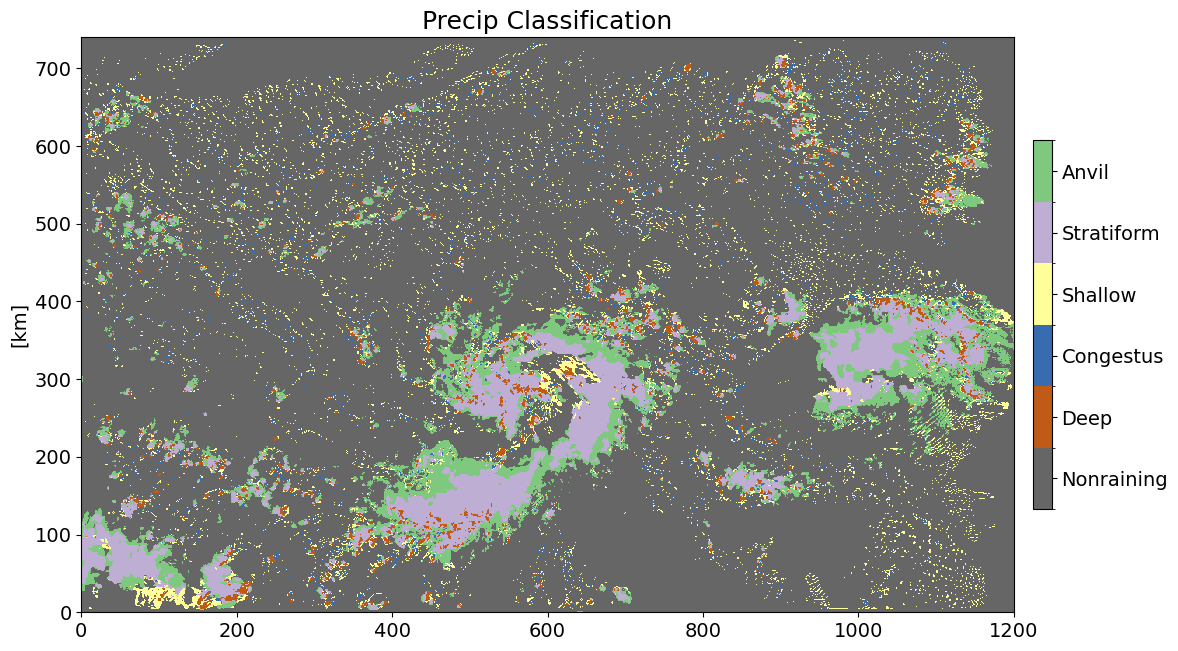

In [10]:
bounds = np.array([-0.5, .5, 1.5, 2.5, 3.5, 4.5, 5.5])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=6)
nlevs = len(bounds) - 1
cmap = plt.get_cmap('Accent_r', nlevs)

fig = plt.figure(figsize=(12,10))
fig.set_facecolor('white')

ax = fig.add_subplot(aspect='equal')
plt.pcolormesh(c_type, cmap=cmap, norm=norm)
cbar=plt.colorbar(fraction=0.019, pad=0.02, ticks=(0,1,2,3,4,5))
cbar.set_ticklabels(['Nonraining','Deep', 'Congestus', 'Shallow', 'Stratiform', 'Anvil'])
cbar.ax.tick_params(labelsize=14)
ax.set_ylabel('[km]')
ax.set_title("Precip Classification", size=18)

plt.tight_layout()

### Classification-averaged Vertical profiles
---

In [11]:
# Use mean p_hyd as vertical coordinate
pres = np.mean(p_hyd, axis=(1,2))*1e-2 # Pa --> hPa

In [12]:
# Function to plot class-averaged profiles
def plot_profiles_class(var_profile, precip_list, var_conv, var_strat, xlabel, pres):
    
    fig = plt.figure(figsize=(12,8),facecolor='white')

    # Profile 1
    ax = fig.add_subplot(121)
    ax.plot(var_profile[0], pres, label=precip_list[0], color='blue')
    ax.plot(var_profile[1], pres, label=precip_list[1], color='red')
    ax.plot(var_profile[2], pres, label=precip_list[2], color='green')
    ax.plot(var_conv, pres, label='All', linestyle='--', color='black')
    ax.set_title('Convective', size=16, weight='bold')
    plt.legend(loc='upper right', fontsize=12)
    plt.gca().invert_yaxis()
    ax.axvline(0, color='gray', linestyle='--')
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ytick_loc=np.arange(1000,0,-100)
    plt.yticks(ticks=ytick_loc, size=12)
    plt.ylim(1000, 100)
    # plt.xlim(-0.25,1.25)
    plt.xticks(size=12)
    plt.xlabel(xlabel, size=14, weight='bold')
    plt.ylabel('Pressure [hPa]', size=14, weight='bold')

    # Profile 2
    ax = fig.add_subplot(122)
    ax.plot(var_profile[3], pres, label=precip_list[3], color='blue')
    ax.plot(var_profile[4], pres, label=precip_list[4], color='red')
    ax.plot(var_strat, pres, label='All', linestyle='--', color='black')
    ax.set_title('Stratiform', size=16, weight='bold')
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    plt.legend(loc='upper right', fontsize=12)
    plt.gca().invert_yaxis()
    ax.axvline(0, color='gray', linestyle='--')
    plt.ylim(1000,100)
    # plt.xlim(-0.25,0.4)
    plt.yticks(ticks=ytick_loc, size=12)
    plt.ylim(1000, 100)
    plt.xticks(size=12)
    plt.xlabel(xlabel, size=14, weight='bold')
    plt.ylabel('Pressure [hPa]', size=14, weight='bold')

In [13]:
# Function to get class-averaged profiles
def var_profiles_class(var, c_type, pres, xlabel):
    
    # New classification scheme
    precip_list = ['Deep', 'Congestus', 'Shallow', 'Stratiform', 'Anvil']
    n_class = len(precip_list)
    var_profile = np.empty((n_class,nz))
    for t in range(n_class):
        ind = (c_type == t+1).nonzero()
        var_profile[t,:] = np.mean(var[:,ind[0],ind[1]], axis=1)
    
    ind = ((c_type > 0) & (c_type < 4)).nonzero()
    var_conv = np.mean(var[:,ind[0],ind[1]], axis=1) # convective total
    ind = (c_type > 3).nonzero()
    var_strat = np.mean(var[:,ind[0],ind[1]], axis=1) # stratiform total

   
    plot_profiles_class(var_profile, precip_list, var_conv, var_strat, xlabel, pres)

#### Average w-profiles

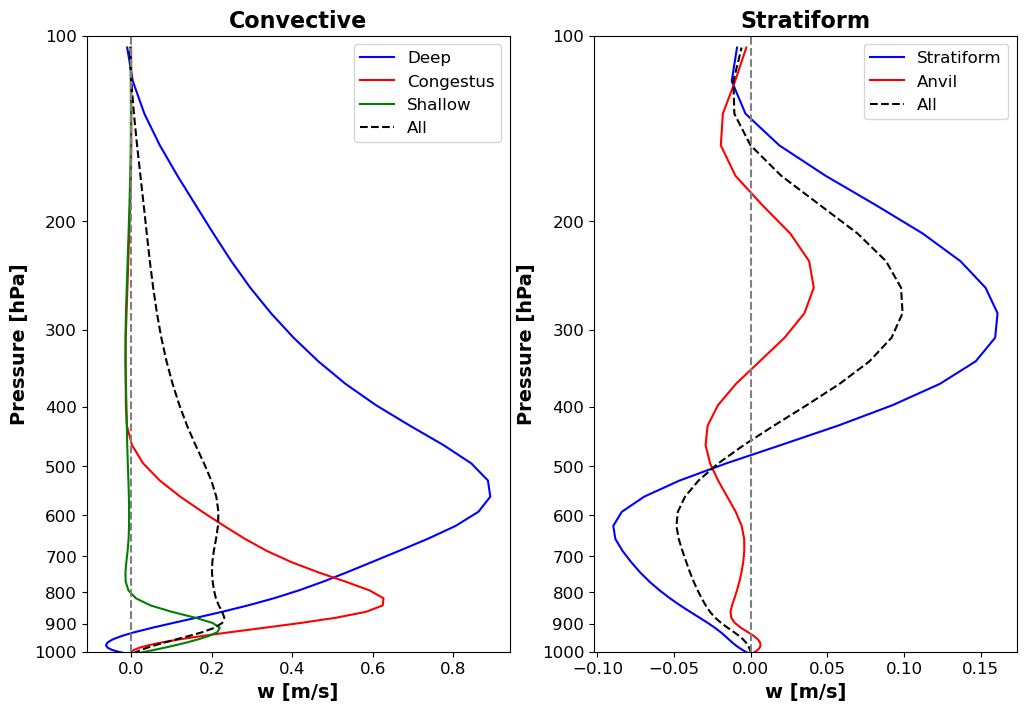

In [14]:
# w profile
var = np.copy(w)
xlabel = 'w [m/s]'
var_profiles_class(var, c_type, pres, xlabel)

#### Avg total hydrometeor profiles

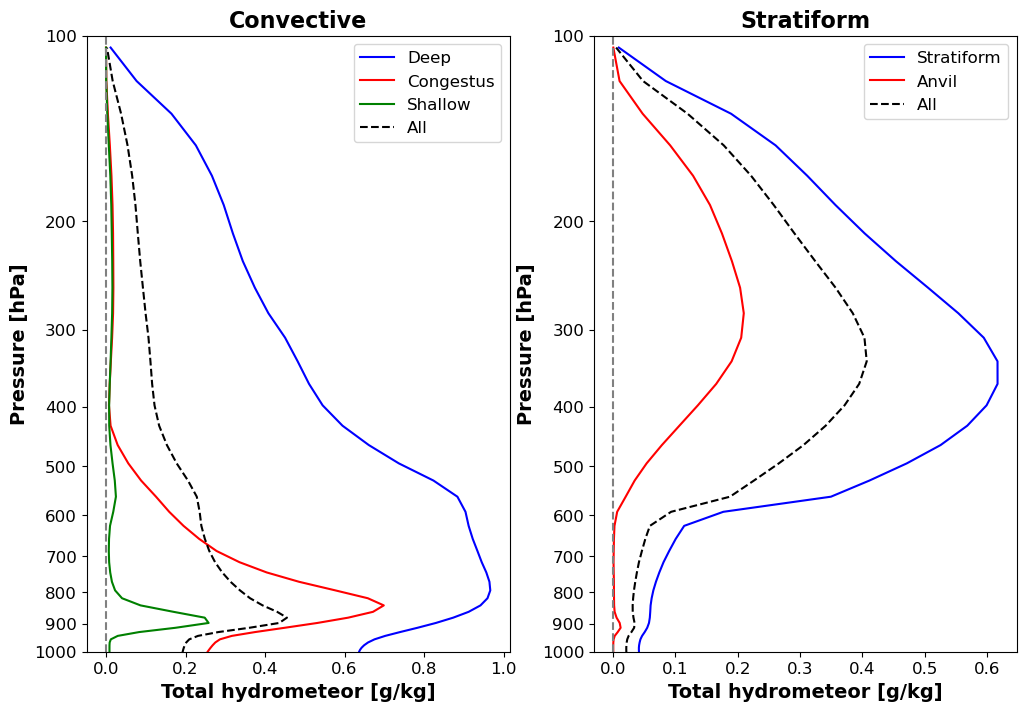

In [15]:
qice = q_var[0]+q_var[1] # [kg/kg]; cloud + rain
qliq = q_var[2]+q_var[3]+q_var[4] # [kg/kg]; ice + snow + graupel
var = qliq+qice
var = np.copy(var)*1e3
xlabel = 'Total hydrometeor [g/kg]'
var_profiles_class(var, c_type, pres, xlabel)

#### Avg cloud liquid hydrometeor profiles

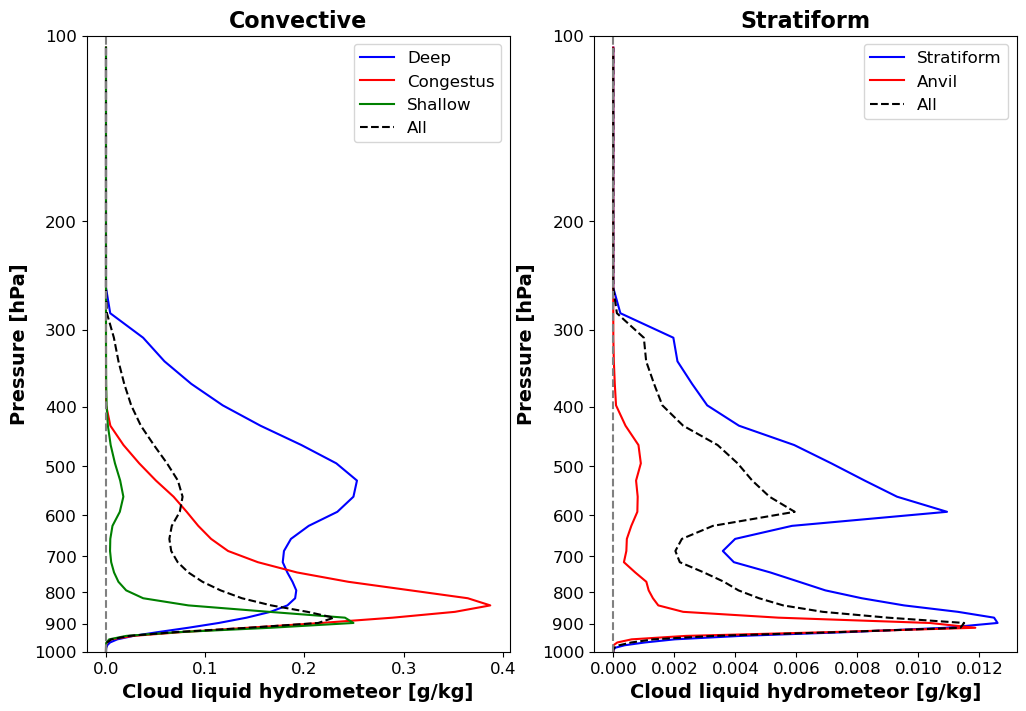

In [16]:
# qice = q_var[0]+q_var[1] # [kg/kg]; cloud + rain
# qliq = q_var[2]+q_var[3]+q_var[4] # [kg/kg]; ice + snow + graupel
var = q_var[0]
var = np.copy(var)*1e3
xlabel = 'Cloud liquid hydrometeor [g/kg]'
var_profiles_class(var, c_type, pres, xlabel)

#### Avg q-rain hydrometeor profiles

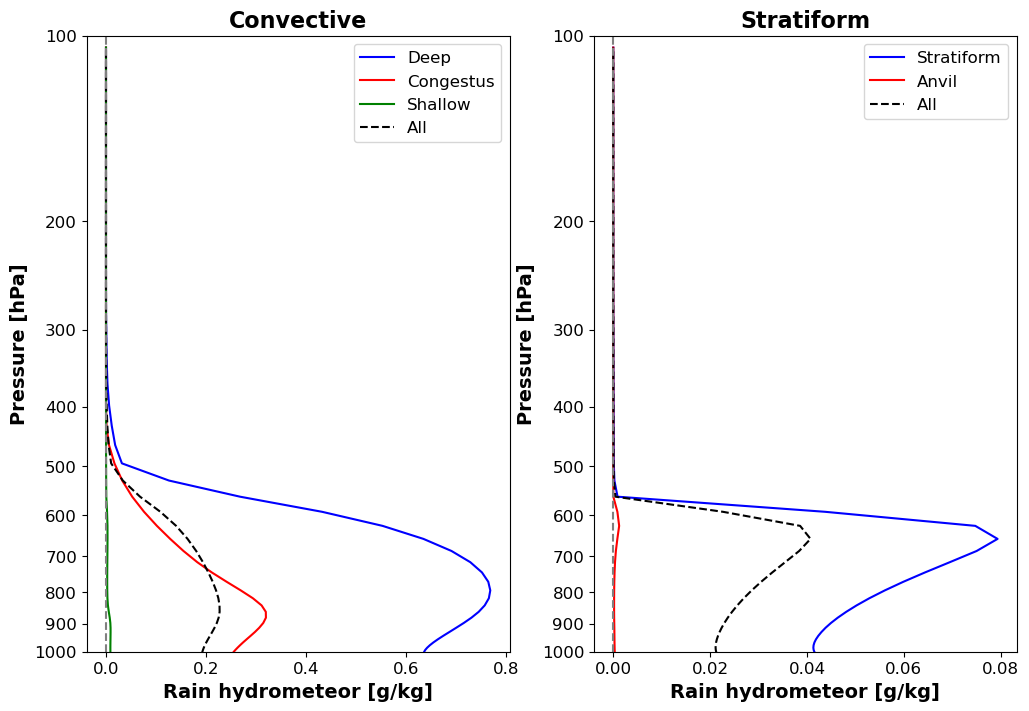

In [17]:
# qice = q_var[0]+q_var[1] # [kg/kg]; cloud + rain
# qliq = q_var[2]+q_var[3]+q_var[4] # [kg/kg]; ice + snow + graupel
var = q_var[1]
var = np.copy(var)*1e3
xlabel = 'Rain hydrometeor [g/kg]'
var_profiles_class(var, c_type, pres, xlabel)

#### Avg cloud ice hydrometeor profiles

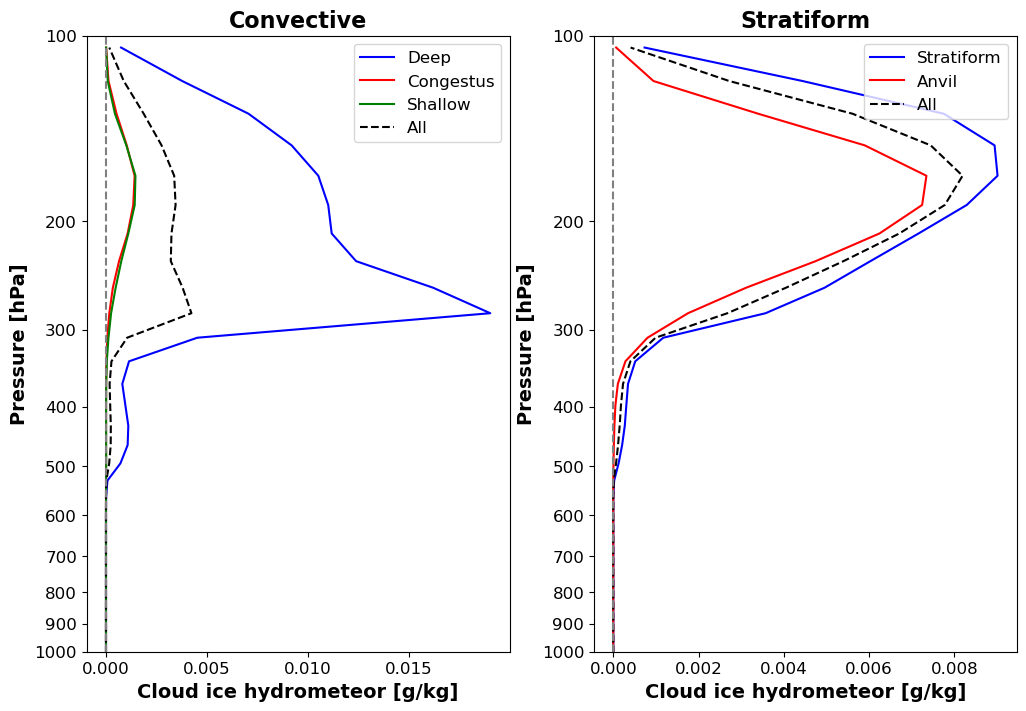

In [18]:
# qice = q_var[0]+q_var[1] # [kg/kg]; cloud + rain
# qliq = q_var[2]+q_var[3]+q_var[4] # [kg/kg]; ice + snow + graupel
var = q_var[2]
var = np.copy(var)*1e3
xlabel = 'Cloud ice hydrometeor [g/kg]'
var_profiles_class(var, c_type, pres, xlabel)

#### Avg snow hydrometeor profiles

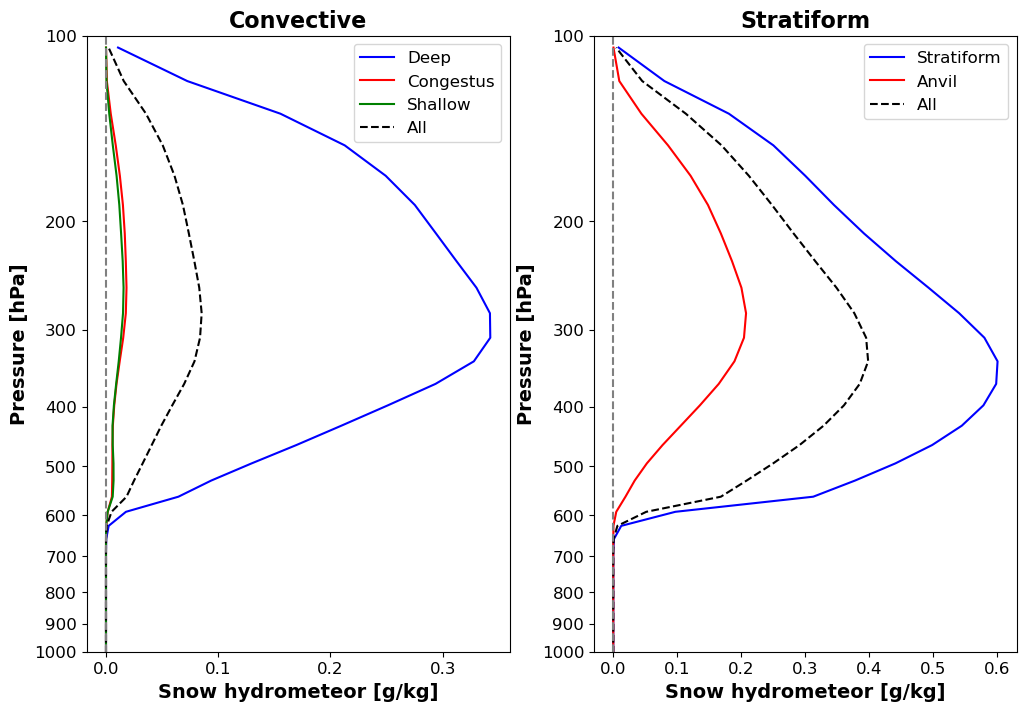

In [19]:
# qice = q_var[0]+q_var[1] # [kg/kg]; cloud + rain
# qliq = q_var[2]+q_var[3]+q_var[4] # [kg/kg]; ice + snow + graupel
var = q_var[3]
var = np.copy(var)*1e3
xlabel = 'Snow hydrometeor [g/kg]'
var_profiles_class(var, c_type, pres, xlabel)

#### Avg graupel hydrometeor profiles

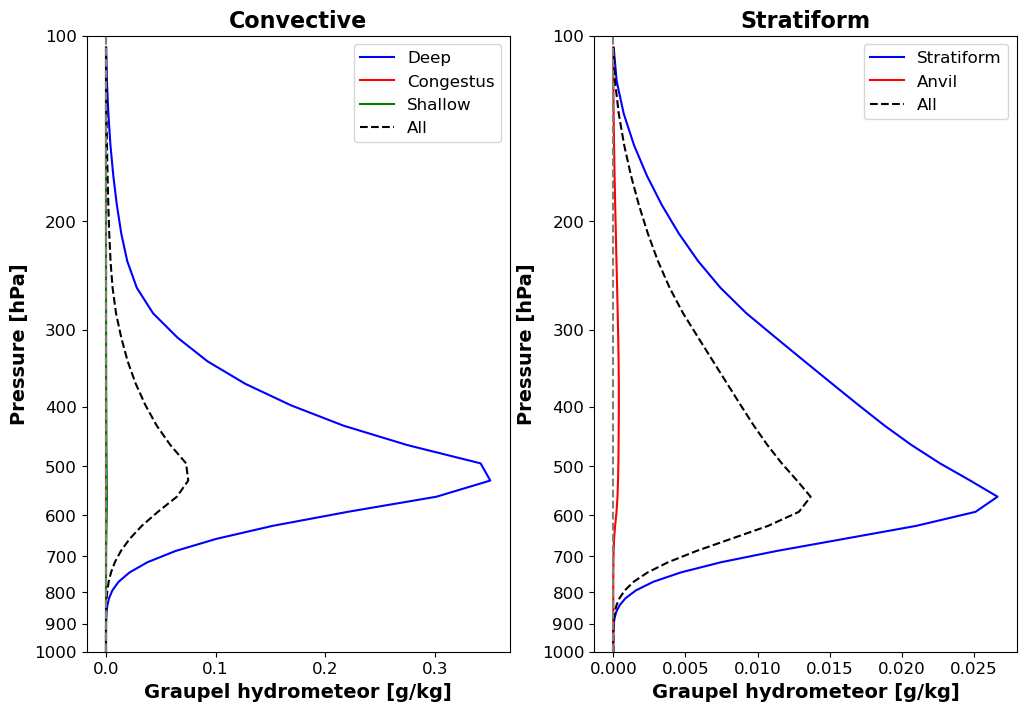

In [20]:
# qice = q_var[0]+q_var[1] # [kg/kg]; cloud + rain
# qliq = q_var[2]+q_var[3]+q_var[4] # [kg/kg]; ice + snow + graupel
var = q_var[4]
var = np.copy(var)*1e3
xlabel = 'Graupel hydrometeor [g/kg]'
var_profiles_class(var, c_type, pres, xlabel)